
=== Run 1/5 ===
[Run 1] Iter 1 F1-illicit: 0.6105
[Run 1] Iter 2 F1-illicit: 0.5950
[Run 1] Iter 3 F1-illicit: 0.5438
[Run 1] Iter 4 F1-illicit: 0.7636
[Run 1] Iter 5 F1-illicit: 0.6605
[Run 1] Iter 6 F1-illicit: 0.7866
[Run 1] Iter 7 F1-illicit: 0.7959
[Run 1] Iter 8 F1-illicit: 0.7687
[Run 1] Iter 9 F1-illicit: 0.7829
[Run 1] Iter 10 F1-illicit: 0.8016
[Run 1] Iter 11 F1-illicit: 0.7814
[Run 1] Iter 12 F1-illicit: 0.7708
[Run 1] Iter 13 F1-illicit: 0.7988
[Run 1] Iter 14 F1-illicit: 0.7982
[Run 1] Iter 15 F1-illicit: 0.7915
[Run 1] Iter 16 F1-illicit: 0.8076
[Run 1] Iter 17 F1-illicit: 0.8018
[Run 1] Iter 18 F1-illicit: 0.8054
[Run 1] Iter 19 F1-illicit: 0.8046
[Run 1] Iter 20 F1-illicit: 0.8070
[Run 1] Iter 21 F1-illicit: 0.8108
[Run 1] Iter 22 F1-illicit: 0.8069
[Run 1] Iter 23 F1-illicit: 0.8095
[Run 1] Iter 24 F1-illicit: 0.8159
[Run 1] Iter 25 F1-illicit: 0.8068
[Run 1] Iter 26 F1-illicit: 0.8157
[Run 1] Iter 27 F1-illicit: 0.8073
[Run 1] Iter 28 F1-illicit: 0.8123
[Run 1] Iter

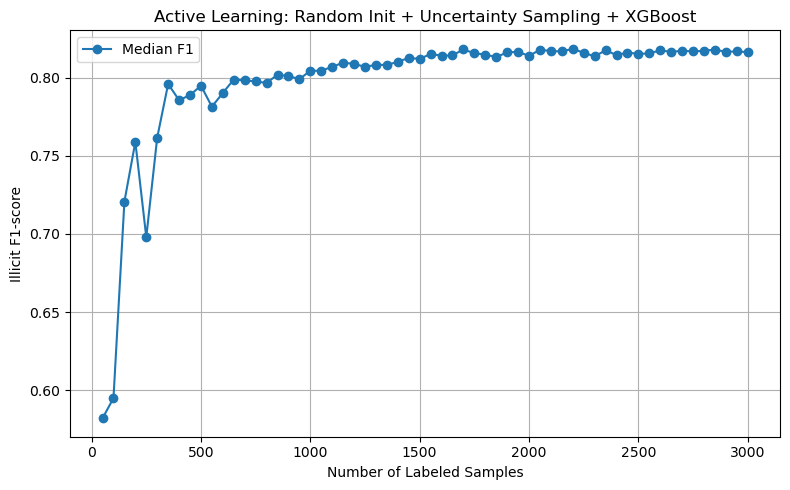

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Assume labeled_df already loaded with 'elliptic_txs_features_labeled.csv'
# and contains 'txId', 'time_step', 'class', and feature columns

# Load data
labeled_df = pd.read_csv("elliptic_txs_features_labeled.csv")

# Split train/test by time_step
train_df = labeled_df[labeled_df['time_step'] <= 34].reset_index(drop=True)
test_df = labeled_df[labeled_df['time_step'] >= 35].reset_index(drop=True)

X_test = test_df.drop(columns=['txId', 'time_step', 'class'])
y_test = (test_df['class'] == 1).astype(int)

feature_columns = [col for col in train_df.columns if col.startswith('feature_') or col.startswith('f')]

# Config
batch_size = 50
max_iterations = 60
N_runs = 5
all_f1_scores = []
warmup_sizes = []
active_sizes = []

for run in range(N_runs):
    print(f"\n=== Run {run+1}/{N_runs} ===")
    unlabeled_pool = train_df.copy().reset_index(drop=True)

    # --- Warm-up via Random Sampling ---
    labeled_pool = unlabeled_pool.sample(n=batch_size, random_state=run).copy()
    unlabeled_pool = unlabeled_pool.drop(labeled_pool.index).reset_index(drop=True)
    warmup_size = len(labeled_pool)
    warmup_sizes.append(warmup_size)

    f1_scores = []

    # --- Active Learning Loop (Uncertainty Sampling) ---
    for iteration in range(1, max_iterations + 1):
        X_train = labeled_pool[feature_columns]
        y_train = (labeled_pool['class'] == 1).astype(int)

        model = xgb.XGBClassifier(
            # use_label_encoder=False,
            eval_metric='logloss',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            tree_method='hist',
            random_state=run
        )
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        f1_scores.append(f1)
        print(f"[Run {run+1}] Iter {iteration} F1-illicit: {f1:.4f}")

        # --- Uncertainty sampling ---
        proba = model.predict_proba(unlabeled_pool[feature_columns])[:, 1]
        uncertainty = np.abs(proba - 0.5)
        select_idx = np.argsort(uncertainty)[:batch_size]

        new_batch = unlabeled_pool.iloc[select_idx]
        labeled_pool = pd.concat([labeled_pool, new_batch], ignore_index=True)
        unlabeled_pool = unlabeled_pool.drop(unlabeled_pool.index[select_idx]).reset_index(drop=True)

        if len(unlabeled_pool) == 0:
            break

    all_f1_scores.append(f1_scores)
    active_sizes.append(len(f1_scores) * batch_size)

# --- Evaluation ---
max_len = max(len(scores) for scores in all_f1_scores)
f1_matrix = np.full((N_runs, max_len), np.nan)
for i, scores in enumerate(all_f1_scores):
    f1_matrix[i, :len(scores)] = scores

median_f1_per_iter = np.nanmedian(f1_matrix, axis=0)
final_median_f1 = np.nanmedian([scores[-1] for scores in all_f1_scores if len(scores) == max_len])

# --- Output ---
print("\n=== Summary ===")
print("Median F1 per Iteration:")
for i, f1 in enumerate(median_f1_per_iter):
    print(f"Iteration {i+1:02d} ({(i+1)*batch_size} samples): Median F1 = {f1:.4f}")

print(f"\nFinal Median F1 (illicit): {round(final_median_f1, 4)}")
print("Average Warm-up size:", int(np.mean(warmup_sizes)))
print("Average Active Learning size:", int(np.mean(active_sizes)))
print("Average Final Training set size:", int(np.mean(np.array(warmup_sizes) + np.array(active_sizes))))

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(median_f1_per_iter)+1)*batch_size, median_f1_per_iter, label='Median F1', marker='o')
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Illicit F1-score")
plt.title("Active Learning: Random Init + Uncertainty Sampling + XGBoost")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
